In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#the jig is a half-line. It extends infinitely in one direction
#the state includes the displacement (signed distance) from the object to the jig

#   |---> (positive displacement)
#   o   jjjjjj...
# -------->  (coordinate frame attached to object)

# in 1D, you can't rotate the object, so the object frame positive x axis always points to the left
# whether you're plotting in world frame or object frame
#       <---| (negative displacement)
# ..jjjj   o
#  --------> (coordinate frame attached to object)

# HOWEVER, if we attach a coordinate frame to the jig, such 0 is the boundary, 
# and the negative direction is occupied by jig, then in this coordinate frame, 
# the displacment to the object is always positive
# BUT now we need to encode whether the object frame points left or right,
# since that's the frame you can specify the actions in.
# (I think this is actually less obvious in 1D than in higher dimensions)


In [3]:
class State(object):
    pass

class MetricState(State):
    def __init__(self, x):
        self.x = x
    def __repr__(self):
        return "MetricState: %s"%(self.x)

class LeftVoidState(State):
    def __init__(self):
        pass
    def __repr__(self):
        return "LeftVoidState"

class RightVoidState(State):
    def __init__(self):
        pass
    def __repr__(self):
        return "RightVoidState"

class ContactPosState(State):
    def __init__(self):
        pass
    def __repr__(self):
        return "ContactNegState"

class ContactNegState(State):
    def __init__(self):
        pass
    def __repr__(self):
        return "ContactPosState"
    
class StateSpace(object):
    def __init__(self, extent=5.0, n_resolution=101):
        self.extent = extent
        self.n_resolution = n_resolution
        self.discretization_free = np.linspace(-self.extent, self.extent, self.n_resolution)
    
        self.others = [LeftVoidState, RightVoidState, ContactPosState, ContactNegState]
        self.n_states = len(self.discretization_free) + len(self.others)
            
    def to_continuous(self, metric_state):
        assert isinstance(metric_state, MetricState)
        return self.discretization_free[metric_state.x]

    def nearest(self, x):
        if x >= self.extent:
            return RightVoidState()
        elif x <= -self.extent:
            return LeftVoidState()
        else:
            i = np.searchsorted(self.discretization_free, x)
            if i == 0:
                return MetricState(0)
            else:
                if abs(self.discretization_free[i-1]-x) < abs(self.discretization_free[i]-x):
                    return MetricState(i-1)
                else:
                    return MetricState(i)

    def interpolate(self, x):
        # return affine combination of states
        # interpolating x when x is outside the extent puts all of the mass in the void.
        if x >= self.extent:
            return [(1.0, RightVoidState())]
        elif x <= -self.extent:
            return [(1.0, LeftVoidState())]
        else:
            i = np.searchsorted(self.discretization_free, x)
            if i == 0:
                raise AssertionError("previous checks should have caught: %s"%(x))
            else:
                a = x - self.discretization_free[i-1]
                b = self.discretization_free[i] - x
                if a<0 or b<0:
                    raise AssertionError("negative distance: %s"%((a,b)))
                
                return [ (b/(a+b), MetricState(i-1)),
                         (a/(a+b), MetricState(i)) ]

       
class state_iterator:
    def __init__(self, state_space):
        self.state_space = state_space

    def __iter__(self):
        return zrange_iter(self.state_space)

class zrange_iter:
    def __init__(self, state_space):
        self.i = 0
        self.state_space = state_space

    def __iter__(self):
        # Iterators are iterables too.
        # Adding this functions to make them so.
        return self

    def next(self):
        if self.i < len(self.state_space.others):
            i = self.i
            self.i += 1
            return (self.state_space.others[i])()
        elif self.i < self.state_space.n_states:
            ii = self.i - len(self.state_space.others)
            self.i += 1
            return MetricState(ii)
            
        else:
            raise StopIteration()

In [4]:
state_space = StateSpace()
state_space.to_continuous(state_space.nearest(2.14))

2.1000000000000005

In [5]:
state_space.nearest(5.1)

RightVoidState

In [6]:
state_space.interpolate(2.5)

[(0.0, MetricState: 74), (1.0, MetricState: 75)]

In [7]:
list(state_iterator(state_space))[0:6]

[LeftVoidState,
 RightVoidState,
 ContactNegState,
 ContactPosState,
 MetricState: 0,
 MetricState: 1]

In [8]:
class Belief(object):
    def __init__(self, state_space=state_space, delta=None):
        self.state_space = state_space
        self.free_p = np.zeros_like(self.state_space.discretization_free)
        # contact_pos is the contact you get from moving from left to right
        self.contact_pos_p = 0.0
        self.contact_neg_p = 0.0
        self.right_void_p = 0.0
        self.left_void_p = 0.0
        
        
        if delta is not None:
            if isinstance(delta, MetricState):
                self.free_p[delta.x] = 1.0
            elif isinstance(delta, LeftVoidState):
                self.left_void_p = 1.0
            elif isinstance(delta, RightVoidState):
                self.right_void_p = 1.0
            elif isinstance(delta, ContactPosState):
                self.contact_pos_p = 1.0
            elif isinstance(delta, ContactNegState):
                self.contact_neg_p = 1.0
            else:
                raise ValueError(delta)
    
    def prob(self, state):
            if isinstance(state, MetricState):
                return self.free_p[state.x]
            elif isinstance(state, LeftVoidState):
                return self.left_void_p
            elif isinstance(state, RightVoidState):
                return self.right_void_p
            elif isinstance(state, ContactPosState):
                return self.contact_pos_p
            elif isinstance(state, ContactNegState):
                return self.contact_neg_p
            else:
                raise ValueError(state)
    
    @staticmethod
    def blend(affine_combo):
        coeffs = np.array([a for (a, b) in affine_combo])
        
        if not np.isclose(np.sum(coeffs), 1.0) or not np.all(coeffs>=0.0):
            raise ValueError("invalid combination: %s"%(coeffs))
        
        #assume each belief is normalized
        blended = Belief()
        
        for (a,b) in affine_combo:
            blended.free_p += a*b.free_p
            blended.contact_pos_p += a*b.contact_pos_p
            blended.contact_neg_p += a*b.contact_neg_p
            blended.right_void_p += a*b.right_void_p
            blended.left_void_p += a*b.left_void_p
        
        if not np.isclose(blended.sum(), 1.0):
            raise AssertionError("sum should have come out to 1.0: %s"%(blended.sum()))
        
        return blended
            
    def something(self):
        self.free_p = 1.0 * np.ones_like(self.state_space.discretization_free)
        self.free_p *= np.random.rand(len(self.state_space.discretization_free))
        
        self.contact_pos_p = 1.0
        self.contact_neg_p = 1.0
        self.right_void_p = 0.1
        self.left_void_p = 0.1
    
        self.normalize()

    def sum(self):
        return self.contact_pos_p + self.contact_neg_p + self.right_void_p + self.left_void_p + self.free_p.sum()
    
    def normalize(self):
        eta = 1.0/(self.sum())
        self.contact_pos_p *= eta
        self.contact_neg_p *= eta
        self.free_p *= eta
        self.right_void_p *= eta
        self.left_void_p *= eta


    def plot(self, ax, frame="object", p_metric_kwargs=dict(color='grey',linestyle="")):
        belief = self
    
        artists=[]

        def plot_single_stem(ax, x, y, 
                             marker_kwargs=dict(markersize=5.0, alpha=1.0, color='darkblue'), 
                             stemline_kwargs=dict(linewidth=4.0, alpha=0.5, color='dimgrey')):
            a = [] #store artists
            a.extend(
                ax.plot([x, x], [0.0, y], **stemline_kwargs))
            
       
            a.extend(
                ax.plot([x], [y], marker='s', **marker_kwargs))
            return a
        
        # contact_pos is the contact you get from moving from left to right
        artists.extend(plot_single_stem(ax, -0.05, belief.contact_pos_p))
        artists.extend(plot_single_stem(ax, 0.05, belief.contact_neg_p))
        artists.extend(plot_single_stem(ax, -belief.state_space.extent, belief.left_void_p))
        artists.extend(plot_single_stem(ax, belief.state_space.extent, belief.right_void_p))
        
        a = ax.plot(belief.state_space.discretization_free, belief.free_p, marker=".", **p_metric_kwargs)
        artists.extend(a)

        return artists

    def metric_mean(self):
        s = self.free_p.sum()
        if s == 0:
            raise ValueError("Metric manifold has zero probability")
        if s>1:
            raise ValueError("Metric manifold had %s>1 probability"%(s))
        return np.dot(self.free_p/s, self.state_space.discretization_free)
    
    def metric_variance(self):
        m = self.metric_mean()
        s = self.free_p.sum()
        return np.dot(self.free_p/s, (self.state_space.discretization_free-m)**2)

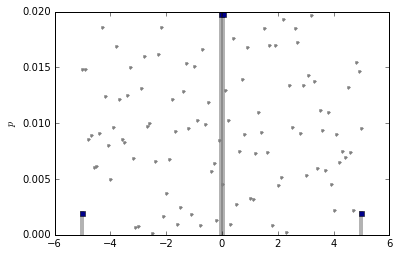

In [9]:
def setup_belief_plot(ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.axhline(0.0)
    ax.set_ylabel(r"$p$")
    return ax

ax = setup_belief_plot()
b = Belief()
b.something()
b.plot(ax);

In [10]:
def ideally_identity(x):
    # interpolate a continuous point onto the metric part
    # convert to a distribution over the metric states (a Belief)
    # take the mean of the belief
    affine_combo = state_space.interpolate(x)
    affine_combo = [(a,Belief(delta=b)) for (a,b) in affine_combo]
    return Belief.blend(affine_combo).metric_mean()

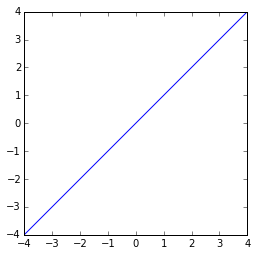

In [11]:
#a sort of unit test. the line should be straight with slope=1
x = np.linspace(-4,4,10000)
y = map(ideally_identity, x)
plt.plot(x,y)
plt.gca().set_aspect(1.0)

In [12]:
class Action(object):
    pass


class GuardedVelocity(Action):
    def __init__(self, velocity):
        self.velocity = velocity
        #self.time_left = 1.0
        #self.finished = False

    def propogate_belief(self, belief, dt=0.1):
        to_blend = []
        for state in state_iterator(state_space):
            a = belief.prob(state)
            b = self.propogate_state(state, dt)
            to_blend.append( (a, b) )
        
        return Belief.blend(to_blend)

    def propogate_state(self, state, dt=0.1):     
        if isinstance(state, MetricState):
            x = state_space.to_continuous(state)
            xprime = x + dt*self.velocity
            
            if x*xprime >= 0:
                affine_combo = state_space.interpolate(xprime)
                affine_combo = [(a,Belief(delta=b)) for (a,b) in affine_combo]
                b = Belief.blend(affine_combo)
            else:
                # made contact
                # TODO this would activate a guard, probably. and the termination condition would be set
                if x < 0:
                    b = Belief(delta=ContactPosState())
                elif x > 0:
                    b = Belief(delta=ContactNegState())
                else:
                    raise AssertionError("just checked this")

        elif isinstance(state, ContactPosState) or isinstance(state, ContactNegState):
            contact_direction = 1.0 if isinstance(state, ContactPosState) else -1.0
            if contact_direction * self.velocity >= 0:
                #pushing into contact, so stay with same contact
                b = Belief(delta=state)
            else:
                #moving away from contact. with probability alpha, stay in contact
                alpha = 0.1
                
                xprime = 0.0 + dt*self.velocity
                affine_combo = state_space.interpolate(xprime)
                affine_combo = [(a,Belief(delta=b)) for (a,b) in affine_combo]
                b_metric = Belief.blend(affine_combo)
                b_contact = Belief(delta=state)
                
                b = Belief.blend([  (alpha, b_contact),
                                    (1-alpha, b_metric)])

        elif isinstance(state, RightVoidState) or isinstance(state, LeftVoidState):
            void_direction = 1.0 if isinstance(state, RightVoidState) else -1.0
            if void_direction * self.velocity >= 0:
                #going further into void, so stay in same void
                b = Belief(delta=state)
            else:
                #moving toward metric. with probability alpha, stay in the void
                alpha = 0.9
                
                void_fringe = state_space.extent * void_direction
                xprime = void_fringe + dt*self.velocity
                affine_combo = state_space.interpolate(xprime)
                affine_combo = [(a,Belief(delta=b)) for (a,b) in affine_combo]
                b_metric = Belief.blend(affine_combo)
                b_void = Belief(delta=state)
                
                b = Belief.blend([  (alpha, b_void),
                                    (1-alpha, b_metric)])

        return b
        
        

class Position(Action):
    def __init__(self):
        self.time_left = 1.0

In [13]:
action = GuardedVelocity(1.0)

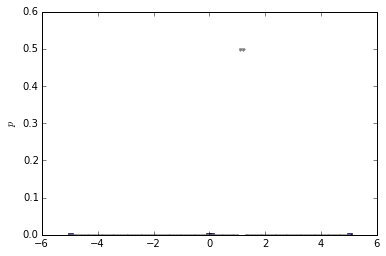

In [14]:
b = action.propogate_state(state_space.nearest(1.0), dt=0.15)
ax = setup_belief_plot()
b.plot(ax);

In [15]:
b.metric_mean()

1.1499999999999999

0.0049999999999999923

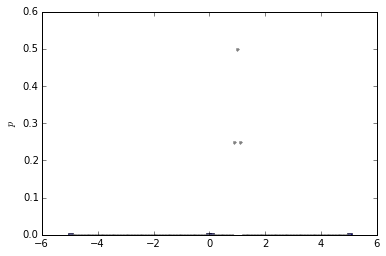

In [16]:
action = GuardedVelocity(-1.0)
b = action.propogate_belief(b, dt=0.15)
ax = setup_belief_plot()
b.plot(ax);
b.metric_variance()